In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u

import sys
sys.path.insert(0, '../')

In [2]:
from astropy.io import ascii

names = ("Recent Venus, Runaway Greenhouse, Maximum Greenhouse, Early Mars, "
         "Runaway Greenhouse for 5 ME, Runaway Greenhouse for 0.1 ME")

kopparapu_data = """   1.77600E+00   1.10700E+00   3.56000E-01   3.20000E-01   1.18800E+00   9.90000E-01
   2.13600E-04   1.33200E-04   6.17100E-05   5.54700E-05   1.43300E-04   1.20900E-04
   2.53300E-08   1.58000E-08   1.69800E-09   1.52600E-09   1.70700E-08   1.40400E-08
  -1.33200E-11  -8.30800E-12  -3.19800E-12  -2.87400E-12  -8.96800E-12  -7.41800E-12
  -3.09700E-15  -1.93100E-15  -5.57500E-16  -5.01100E-16  -2.08400E-15  -1.71300E-15"""

kopp_table = ascii.read(kopparapu_data, names=names.split(', '))

In [3]:
kopp_teffs = np.linspace(2500, 6000, 15)

def seff(limit, teff):
    seff_sun, a, b, c, d = kopp_table[limit].data
    return seff_sun + np.polyval([d, c, b, a, 0], (teff - 5780))

seffs_max = seff('Maximum Greenhouse', kopp_teffs)
seffs_runaway = seff('Runaway Greenhouse', kopp_teffs)
seffs_mars = seff('Early Mars', kopp_teffs)
seffs_venus = seff('Recent Venus', kopp_teffs)

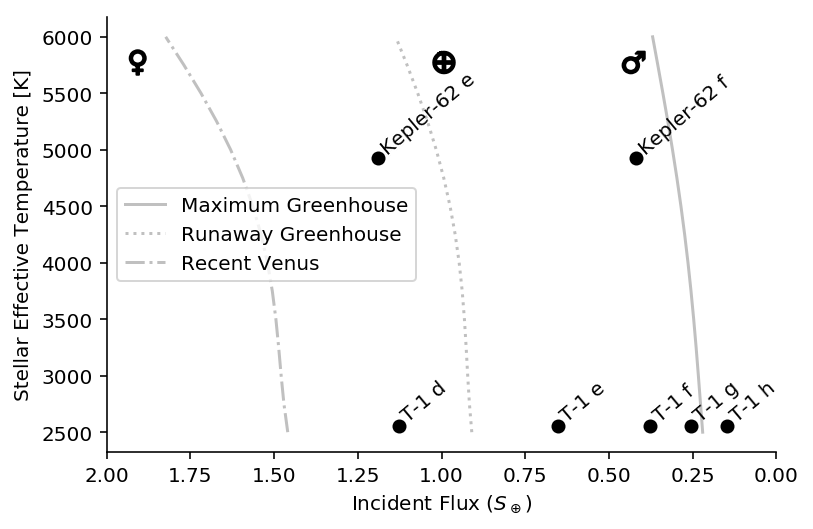

In [5]:
from libra import trappist1, kepler296, kepler62
from astropy.constants import sigma_sb, R_sun, R_earth, L_sun

# Earth, Venus, Mars
R_venus = 0.95 * R_earth
R_mars = 0.53 * R_earth
a_mars = 1.524 * u.AU
a_venus = 0.723 * u.AU
a_earth = 1 * u.AU

# Insolation relative to Earth: 

def insol(a, r_star, t_eff, t_sun=5780*u.K, a_earth=1*u.AU):
    return float((a_earth/R_sun * r_star/a)**2 * (t_eff / t_sun)**4)

irr_venus = insol(a_venus, R_sun, 5780*u.K)
irr_earth = insol(a_earth, R_sun, 5780*u.K)
irr_mars = insol(a_mars, R_sun, 5780*u.K)

names = ['T-1', 'Kepler-296', 'Kepler-62']
systems = [trappist1, kepler296, kepler62]
planetlists = [list('bcdefgh'), list('bcdef'), list('bcdef')]
T_effs = u.Quantity([2559, 3440, 4926], u.K)
R_stars = np.array([0.117, 0.322, 0.662]) * R_sun

fig, ax = plt.subplots()

for i, star, name, planets, T_eff, R_star in zip(range(len(systems)), systems, names,
                                                 planetlists, T_effs, R_stars):

    if name != 'Kepler-296':

        for planet in planets: 
            # Semimajor axis / stellar radius
            a = star(planet).a * R_star
            irradiance_ratio = insol(a, R_star, T_eff)

            ax.scatter(irradiance_ratio, T_eff.value, color='k')
            if irradiance_ratio < 2:
                ax.annotate("{0} {1}".format(name, planet), 
                            xy=(irradiance_ratio, T_eff.value), xycoords='data',
                            ha='left', va='bottom', rotation=40)


kwargs = dict(s=150, color='k')
ax.scatter(irr_venus, 5780, marker=u'$\u2640$', **kwargs)
ax.scatter(irr_mars,  5780, marker=u'$\u2642$', **kwargs)
ax.scatter(irr_earth, 5780, marker='$\oplus$', **kwargs)

ax.plot(seffs_max, kopp_teffs, color='silver', ls='-', label='Maximum Greenhouse')
ax.plot(seffs_runaway, kopp_teffs, color='silver', ls=':', label='Runaway Greenhouse')
#ax.plot(seffs_mars, kopp_teffs, color='silver', ls`='-.', label='Early Mars')
ax.plot(seffs_venus, kopp_teffs, color='silver', ls='-.', label='Recent Venus')

ax.set_xlim([0.00, 2])
#fig.tight_layout()

ax.legend(loc='center left')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.invert_xaxis()
ax.set(xlabel='Incident Flux ($S_\oplus$)', ylabel='Stellar Effective Temperature [K]')
fig.savefig('census.pdf', bbox_inches='tight')
plt.show()